In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 33% 5.00M/15.1M [00:00<00:00, 46.1MB/s]
100% 15.1M/15.1M [00:00<00:00, 101MB/s] 


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-mri-images-for-brain-tumor-detection.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras import layers, models, applications, regularizers

In [10]:
import os
import shutil

# Define the path to the content directory
content_dir = '/content'  # Replace with the actual path to the content directory

# Define the paths for the yes and no directories
yes_dir = os.path.join(content_dir, 'yes')
no_dir = os.path.join(content_dir, 'no')

# Define the path for the new dataset directory
dataset_dir = os.path.join(content_dir, 'dataset')

# Create the dataset directory if it doesn't exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Move the yes and no directories into the dataset directory
shutil.move(yes_dir, dataset_dir)
shutil.move(no_dir, dataset_dir)

print(f'Moved "yes" and "no" directories to {dataset_dir}')


Moved "yes" and "no" directories to /content/dataset


In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Directory containing your dataset
directory = '/content/dataset'

# Load training and validation datasets
train_ds = image_dataset_from_directory(
    directory=directory,
    subset='training',
    validation_split=0.2,  # Set validation split ratio
    seed=123,  # Seed for reproducibility
    image_size=(224, 224),
    batch_size=64,
    label_mode='int'  # Adjust based on your needs
)

validation_ds = image_dataset_from_directory(
    directory=directory,
    subset='validation',
    validation_split=0.2,  # Must match the split used for training
    seed=123,  # Seed for reproducibility
    image_size=(224, 224),
    batch_size=64,
    label_mode='int'  # Adjust based on your needs
)


Found 253 files belonging to 2 classes.
Using 203 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.


In [20]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Creates a VGG16 convolutional base model
conv_base=VGG16(
weights='imagenet',
include_top=False,
input_shape=(224,224,3))

# Summary of the model's architecture
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import load_model

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [22]:
for layer in conv_base.layers:
  layer.trainable = False  # Freezing the layers

# Adding a new neural network on top of the frozen convolutional base
x = conv_base.output
x = Flatten()(x)
x = Dense(256,activation='relu')(x)

# Adds a final output layer to the neural network
x = Dense(1, activation='sigmoid')(x)

# Represents the complete neural network architecture
modelv = Model(inputs=conv_base.input, outputs=x)

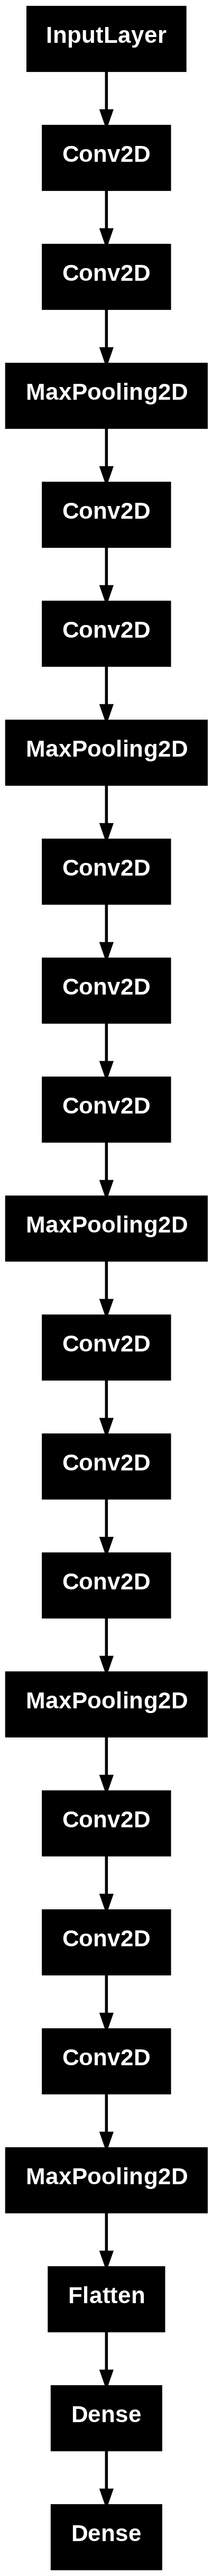

In [23]:
# Visualize the architecture of the neural network model
from keras.utils import plot_model
plot_model(modelv)

In [24]:
modelv.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:
# Compile the neural network model
modelv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# Trains the model using the fit method
callback = keras.callbacks.EarlyStopping(monitor='loss',patience=3)

history = modelv.fit(
    train_ds,
    epochs=10,
    callbacks=[callback],
    validation_data=validation_ds
)
# Fit method returns a History object, which contains the training and validation metrics for each epoch

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.6016 - loss: 33.7139 - val_accuracy: 0.3800 - val_loss: 40.6163
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 389ms/step - accuracy: 0.6402 - loss: 19.6864 - val_accuracy: 0.8400 - val_loss: 6.9385
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - accuracy: 0.7999 - loss: 6.2938 - val_accuracy: 0.9000 - val_loss: 6.0107
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - accuracy: 0.8946 - loss: 2.7911 - val_accuracy: 0.8800 - val_loss: 3.6074
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 0.9349 - loss: 1.1661 - val_accuracy: 0.9000 - val_loss: 3.4589
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 0.9326 - loss: 0.6038 - val_accuracy: 0.9000 - val_loss: 2.5164
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.9885 - loss: 0.0263 - val_accuracy: 0.9000 - val_loss: 2.5496
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.9539 - loss: 0.1222 - val_accuracy: 0.8800 - val_los

In [27]:
loss, accuracy = modelv.evaluate(validation_ds)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9200 - loss: 2.1230
Validation Loss: 2.1230454444885254
Validation Accuracy: 0.9200000166893005


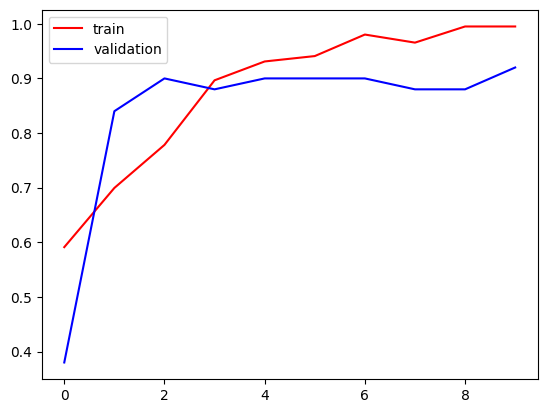

In [28]:
# Training and validation accuracy curves
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

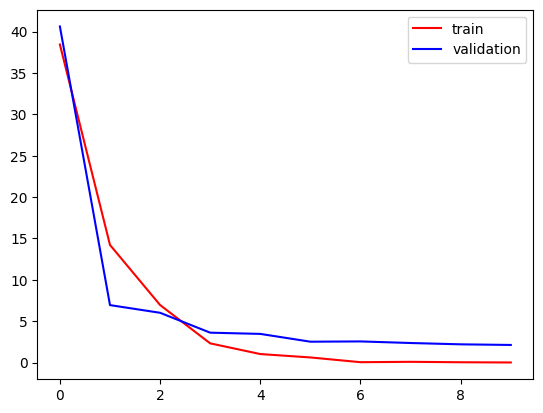

In [29]:
# Training and validation loss curves
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 11s/step
              precision    recall  f1-score   support

    No Tumor       0.89      0.89      0.89        18
       Tumor       0.94      0.94      0.94        32

    accuracy                           0.92        50
   macro avg       0.91      0.91      0.91        50
weighted avg       0.92      0.92      0.92        50



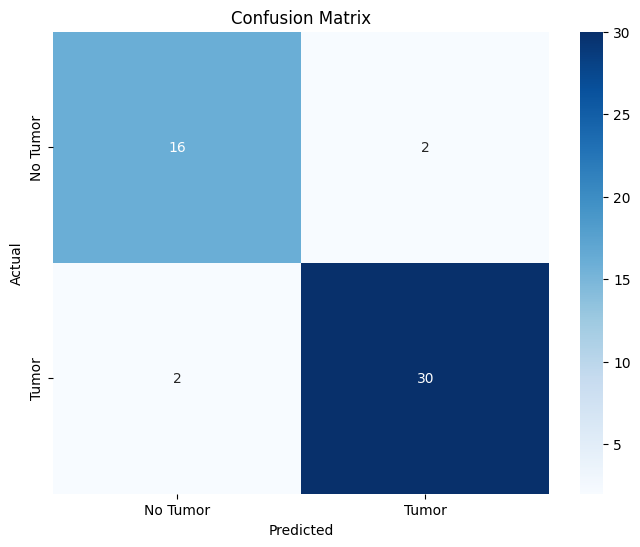

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
true_labels = []
pred_labels = []

for images, labels in validation_ds:
  true_labels.extend(labels.numpy())
  predictions = modelv.predict(images)
  pred_labels.extend((predictions > 0.5).astype(int).flatten()) # Binary classification threshold at 0.5

true_labels = np.array(true_labels) # Convert the lists true_labels into NumPy arrays
pred_labels = np.array(pred_labels) #  Convert the lists pred_labels into NumPy arrays

# Evaluate model's performance on validation set

# Generate the classification report
report = classification_report(true_labels, pred_labels, target_names=['No Tumor', 'Tumor']) # Adjust class names as needed
print(report)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()